In [1]:
import os
import itertools
import pandas as pd
import numpy as np 
import pickle
import collections
import seaborn as sns
from sklearn import preprocessing

# Python tools
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import math
from collections import defaultdict
from functools import partial


In [2]:
# Geometry, shapefiles and projections
import fiona
from shapely.geometry import shape
from shapely.geometry import Point
import pyproj
from descartes import PolygonPatch
from shapely.ops import transform

In [3]:
%matplotlib inline

In [4]:
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/PIN/'

In [5]:
#project = partial(
#    pyproj.transform,
#    pyproj.Proj(init='epsg:29902'), # source coordinate system
#    pyproj.Proj(init='epsg:27700')) # destination coordinate system

def draw(data, col, color_scheme, data_min, data_max):
    cmap = plt.get_cmap(color_scheme)
    norm = Normalize(vmin=data_min, vmax=data_max)
    fig, ax = plt.subplots(figsize=(8,16))

    # Lists of x,y bounds in order to set fig-ax lims
    xs = []
    ys = []
    # Plot GB
    with fiona.open(gb_filename) as gb:
        for country in gb:
            s = shape(country['geometry'])
            p = PolygonPatch(s, color="lightgrey")
            ax.add_patch(p)
            xs += [s.bounds[0],s.bounds[2]]
            ys += [s.bounds[1],s.bounds[3]]

    # Plot NI, correcting for different east/northing zone
    with fiona.open(ni_filename) as ni:
         for country in ni:
#            pyproj.Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
            s = shape(country['geometry'])
#            s = transform(project, s)
            p = PolygonPatch(s, color="lightgrey")
            ax.add_patch(p)
            xs += [s.bounds[0],s.bounds[2]]
            ys += [s.bounds[1],s.bounds[3]]

    # Overlay TTWAS, if non zero distances
    with fiona.open(shp_filename) as ttwas:
        # Plot TTWAs with colour
        for ttwa in ttwas:
            id_ = ttwa['properties']['ttwa11cd']
            #test = ['E30000186', 'S22000065']
            if id_ not in data['TTWA Code'].values:
                continue
            #if id_ not in test:
            #    continue
            row = data[data['TTWA Code'] == id_]
            val = row[col].values[0]
            s = shape(ttwa['geometry'])
            p = PolygonPatch(s, color=cmap(norm(val)))
            xs += [s.bounds[0],s.bounds[2]]
            ys += [s.bounds[1],s.bounds[3]]
            ax.add_patch(p)
            #print(row)
    # Set bounds
    ax.set_xlim(min(xs),max(xs))
    ax.set_ylim(min(ys),max(ys))
    ax.axis('off')
    all_labels = [val for val in np.unique(data[col])]
    select_labels = [np.min(all_labels), np.percentile(all_labels, 25), np.percentile(all_labels, 50), 
                     np.percentile(all_labels, 75), np.max(all_labels)]
    select_labels2 = [round(elem,2) for elem in select_labels]
    select_colors = [cmap(norm(val)) for val in select_labels]
    p1 = mpatches.Patch(color=select_colors[0], linewidth=0)
    p2 = mpatches.Patch(color=select_colors[1], linewidth=0)
    p3 = mpatches.Patch(color=select_colors[2], linewidth=0)
    p4 = mpatches.Patch(color=select_colors[3], linewidth=0)
    p5 = mpatches.Patch(color=select_colors[4], linewidth=0)
    plt.legend((p1,p2,p3,p4,p5,), 
               (select_labels2[0],select_labels2[1], select_labels2[2], select_labels2[3], select_labels2[4],))
    plt.show()

In [14]:
# Shape files for TTWAs, GB and NI
map_files_folder = '/Users/stefgarasto/Google Drive/Documents/data/Map-files/'
shp_filename = map_files_folder + 'Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom.shp'
gb_filename = map_files_folder + 'Countries_December_2016_Ultra_Generalised_Clipped_Boundaries_in_Great_Britain.shp'
ni_filename = map_files_folder + 'OSNI_Open_Data_Largescale_Boundaries__Country_2016.shp'

## Skill cluster diversity

In [25]:
#growth = pd.read_csv(os.path.join(output_dir, 'ttwa_growth.csv'), encoding = 'utf-8')
folder2 = '/Users/stefgarasto/Google Drive/Documents/data/'
ttwa_file = folder2 + 'ONS/Travel_to_Work_Areas_December_2011_Boundaries.csv'
# first, load the list of all TTWA
ttwa_data = pd.read_csv(ttwa_file)
growth = ttwa_data
growth['Growth'] = np.random.randn(len(ttwa_data))
growth = growth.rename(columns = {'ttwa11cd': 'TTWA Code', 'ttwa11nm': 'TTWA Name'})

In [26]:
growth.head()

,objectid,TTWA Code,TTWA Name,st_areashape,st_lengthshape,Growth
0,1,E30000004,Barnsley,3.424767e+08,131741.189828,-1.738895
1,2,E30000018,Bradford,3.439266e+08,123178.197969,-1.252643
2,3,E30000046,Dorchester and Weymouth,7.199390e+08,232334.633989,1.968422
3,4,E30000054,Grantham,7.779521e+08,189238.098641,0.928748
4,5,E30000061,Hastings,4.567289e+08,144067.660554,0.427772


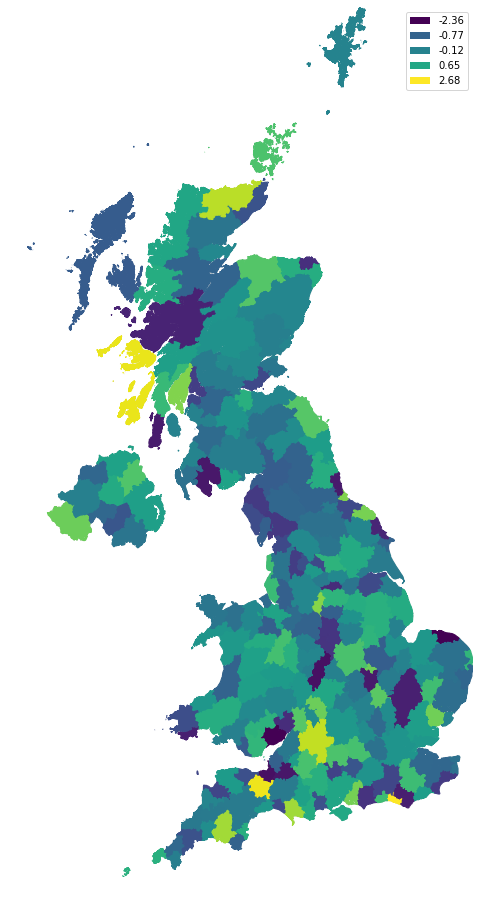

In [27]:
#Second level
draw(growth, 'Growth', 'viridis', np.min(growth['Growth']), np.max(growth['Growth']))